#import our numerical workhorses

In [131]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [144]:
#define log posterior (modified from class notes)
def log_posterior_delta_gamma(p):
    """
    Log Posterior probability distribution for delta and gamma.
    
    Input is arrays delta and gamma.  Returns a 2D array for various 
    values of gamma.
    """
    delta, gamma = p
    n_r1=9
    n_1=35
    n_r2=33
    n_2=36
    # Make 2D versions of delta and gamma
    dd, gg = np.meshgrid(delta, gamma)

    # Initialize output array
    out = np.empty_like(dd)
    # Populate np.inf values based on outlawed deltas and gammas

    out[abs(dd) > 1] = np.inf
    
    out[gg < 0] = np.inf
    out[gg > 2] = np.inf
    out[(gg <= abs(dd))] = np.inf
    out[(gg >= (2-abs(dd)))] = np.inf

    # Get indices with nonzero values
    inds = (out != np.inf)
    # Compute log probability
    log_P = scipy.special.gammaln(n_1 + 2) - scipy.special.gammaln(n_r1 + 1) \
            + scipy.special.gammaln(n_2 + 2) - scipy.special.gammaln(n_r2 + 1) \
            - scipy.special.gammaln(n_1 - n_r1 + 1) \
            - scipy.special.gammaln(n_2 - n_r2 + 1) -np.log(2) \
            + n_r1 * np.log((gg[inds] - dd[inds]) / 2) \
            + n_r2 * np.log((gg[inds] + dd[inds]) / 2) \
            + (n_1 - n_r1) * np.log(1 - (gg[inds] - dd[inds]) / 2) \
            + (n_2 - n_r2) * np.log(1 - (gg[inds] + dd[inds]) / 2)
            
    # Populate non-infinite values and return
    out[inds] = log_P
    
    return out

In [145]:
n_dim = 2        # number of parameters in the model (delta and gamma)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in
np.random.seed(42)


In [146]:
p0 = np.empty((n_walkers, n_dim))

p0[:,0] = np.random.uniform(-1,1, n_walkers)            # delta-uniform selection from -1 to 1
#p0[:,1] = np.random.uniform( abs(np.min(p0[:,0])), abs(np.max(p0[:,0])), n_walkers)
p0[:,1] = np.random.uniform( 0, 2, n_walkers)

In [147]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_delta_gamma)

In [148]:
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [149]:
_ = sampler.run_mcmc(pos, n_steps)

In [150]:
print(sampler.chain.shape)
print(sampler.flatchain.shape)

(50, 5000, 2)
(250000, 2)


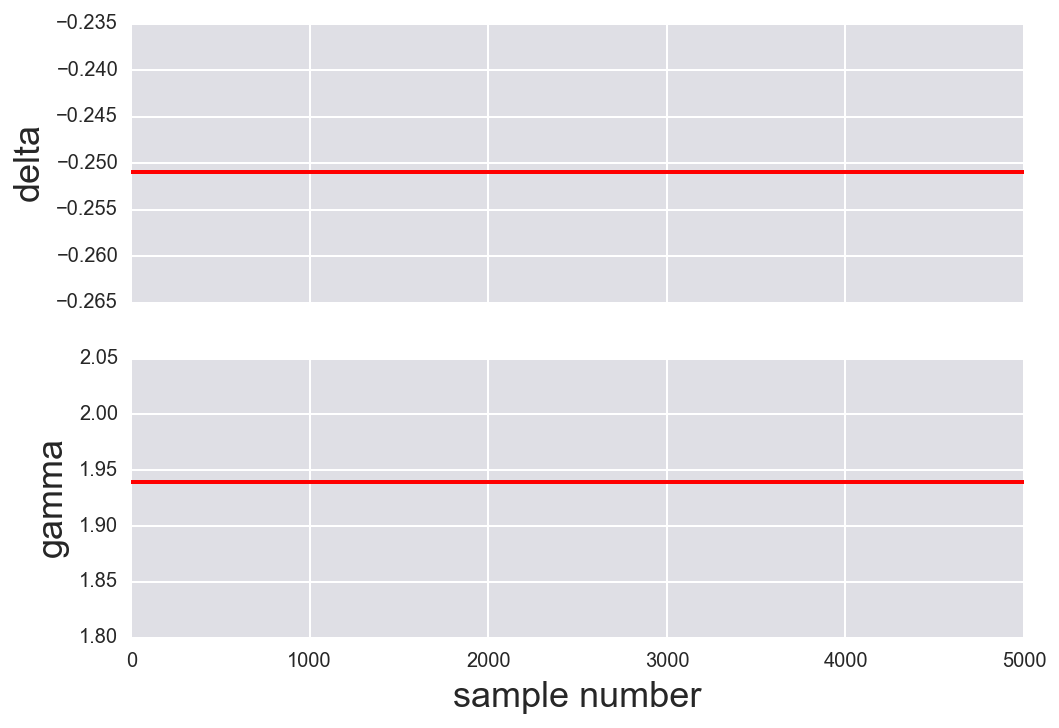

In [151]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('delta')
ax[1].set_ylabel('gamma')

In [154]:
sampler.chain[0,:,0].std()

5.5511151231257827e-17

In [142]:
sampler.chain[0,:,1]

array([ 1.93916926,  1.93916926,  1.93916926, ...,  1.93916926,
        1.93916926,  1.93916926])

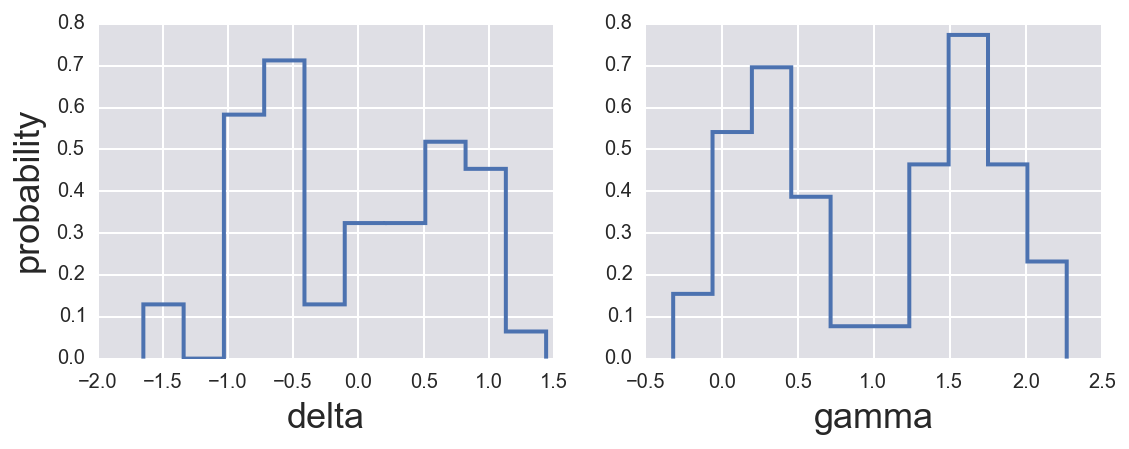

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(sampler.flatchain[:,i], bins=10, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel('delta')
ax[1].set_xlabel('gamma')
ax[0].set_ylabel('probability')

In [ ]:
df2 = pd.read_csv('data/reeves_gradient_width_various_methods.csv', comment='#', header=[0,1])
df2.head()